1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [42]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [43]:
N=20000
data=pd.read_csv('data/data_000637.txt',sep=",",header=1,nrows=N)
data=pd.DataFrame(data)
data.columns=['HEAD','FPGA','TDC_CHANNEL','ORBIT_CNT','BX_COUNTER','TDC_MEAS']
print(data)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          124  3869200167        2374        27
1         1     0           63  3869200167        2553        28
2         1     0           64  3869200167        2558        19
3         1     0           64  3869200167        2760        25
4         1     0           63  3869200167        2762         4
...     ...   ...          ...         ...         ...       ...
19995     1     0           63  3869200366        2517         6
19996     1     0           32  3869200366        2519         5
19997     1     0           17  3869200366        2522        21
19998     1     0           64  3869200366        2522         0
19999     1     0           23  3869200366        2512        27

[20000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [44]:
x=max(data.loc[:,'BX_COUNTER'])
print("With N=20000, the estimated number of BX in a ORBIT is:",x)

With N=20000, the estimated number of BX in a ORBIT is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [45]:
a=data.loc[:,'TDC_MEAS']
b=data.loc[:,'BX_COUNTER']
c=data.loc[:,'ORBIT_CNT']
start=(x*c[0]+b[0])*25+(25/30)*a[0]
d=(x*c+b)*25+(25/30)*a-start
e=pd.to_timedelta(d)
data['NANOSECONDS']=e
print(data)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0         1     0          124  3869200167        2374        27   
1         1     0           63  3869200167        2553        28   
2         1     0           64  3869200167        2558        19   
3         1     0           64  3869200167        2760        25   
4         1     0           63  3869200167        2762         4   
...     ...   ...          ...         ...         ...       ...   
19995     1     0           63  3869200366        2517         6   
19996     1     0           32  3869200366        2519         5   
19997     1     0           17  3869200366        2522        21   
19998     1     0           64  3869200366        2522         0   
19999     1     0           23  3869200366        2512        27   

                    NANOSECONDS  
0               0 days 00:00:00  
1     0 days 00:00:00.000004475  
2     0 days 00:00:00.000004593  
3     0 days 00:00:00.000009648  
4     0 days 

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [46]:
data_full=pd.read_csv('data/data_000637.txt',sep=",",header=1)
data_full=pd.DataFrame(data_full)
data_full.columns=['HEAD','FPGA','TDC_CHANNEL','ORBIT_CNT','BX_COUNTER','TDC_MEAS']
a_full=data_full.loc[:,'TDC_MEAS']
b_full=data_full['BX_COUNTER']
c_full=data_full['ORBIT_CNT']
d_full=(x*c_full+b_full)*25+(25/30)*a_full
e_full=pd.to_timedelta(d_full)
print(e_full)

0         3 days 23:44:09.004934897
1         3 days 23:44:09.004939373
2         3 days 23:44:09.004939490
3         3 days 23:44:09.004944545
4         3 days 23:44:09.004944578
                     ...           
1310714   3 days 23:44:09.985075886
1310715   3 days 23:44:09.985075909
1310716   3 days 23:44:09.985075925
1310717   3 days 23:44:09.985076050
1310718   3 days 23:44:09.985075890
Length: 1310719, dtype: timedelta64[ns]


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [47]:
n0=data_full.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
print(n0)
n0=n0.sort_values(ascending=False)
print(n0)
print('First three: '+ str(n0.iloc[0:3]))

TDC_CHANNEL
1       29653
2       34271
3       23463
4       28755
5       16435
        ...  
129        37
130        71
137        68
138        70
139    108059
Name: TDC_CHANNEL, Length: 133, dtype: int64
TDC_CHANNEL
139    108059
64      66020
63      64642
61      49479
62      49349
        ...  
126       606
130        71
138        70
137        68
129        37
Name: TDC_CHANNEL, Length: 133, dtype: int64
First three: TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [48]:
unique=data_full['ORBIT_CNT'].nunique()
print("Non-empty orbits:", unique)

Non-empty orbits: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [49]:
n1=data_full.query('TDC_CHANNEL==139')
n1=n1.groupby('ORBIT_CNT')['ORBIT_CNT'].count()
print(len(n1))

10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [62]:
f1=data_full.query('FPGA==0')
f2=data_full.query('FPGA==1')
s1=f1.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
s2=f2.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
index1=s1.index
index2=s2.index
values1=s1.values
values2=s2.values
sr1=pd.Series(values1, index=index1)
print(sr1)
sr2=pd.Series(values2, index=index2)
print(sr2)

TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Length: 124, dtype: int64
TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

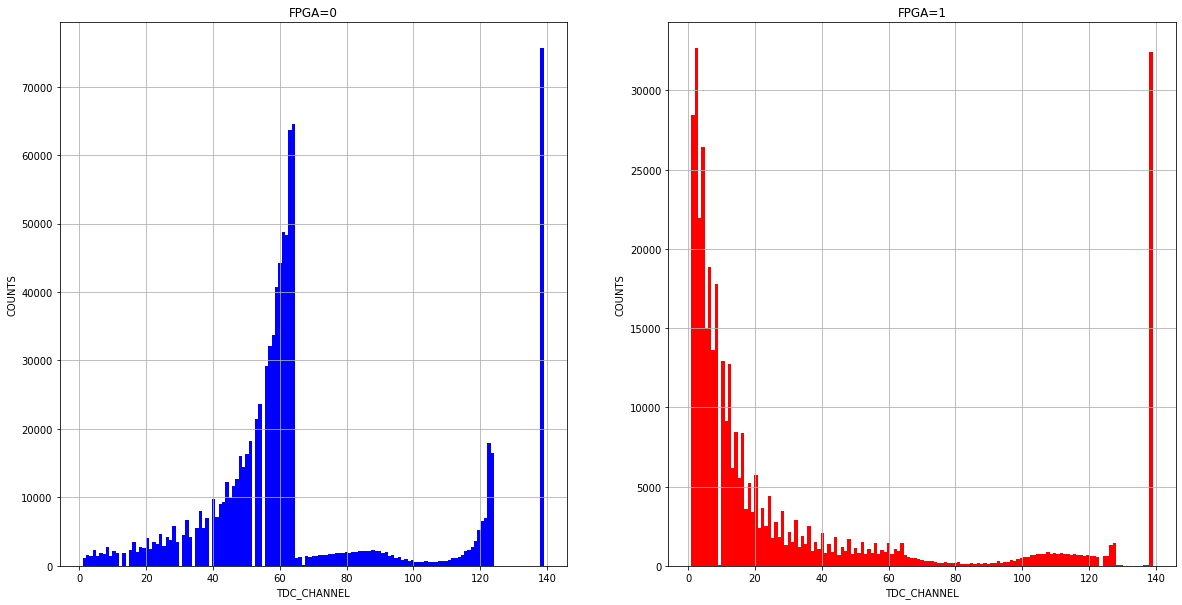

In [65]:
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=(20,10))

axs[0].set_xlabel('TDC_CHANNEL')
axs[0].set_ylabel('COUNTS')
axs[0].set_title('FPGA=0')
axs[0].set_xlabel('TDC_CHANNEL')
axs[0].set_ylabel('COUNTS')
axs[0].grid()

y,bins,_=axs[0].hist(f1['TDC_CHANNEL'],bins=139,density=False,cumulative=False,color='blue')

axs[1].set_xlabel('TDC_CHANNEL')
axs[1].set_ylabel('COUNTS')
axs[1].set_title('FPGA=1')
axs[1].set_xlabel('TDC_CHANNEL')
axs[1].set_ylabel('COUNTS')
axs[1].grid()
y,bins,_=axs[1].hist(f2['TDC_CHANNEL'],bins=139,density=False,cumulative=False,color='red')